# **Fetch Data Quality Analysis Report**


### Table of Contents

1.   Executive Summary
2.   Data Loading & Cleaning for Analysis
 - Column Standardization
 - Schema Validation
 - Handling Missing Values
 - Duplicate Detection

3. Data Quality Checks

 - Referential Integrity Check
 - Orphaned Data Detection
 - Stale User Detection

4. Outlier Analysis & Transformation
 - Outlier Detection (IQR Method)
 - Log Transformation & Data Distribution

5. Data Quality Action plan

6. Key Findings & Next Steps

### 1. Executive Summary

  
  
*   This report evaluates the data quality issues of Fetch's datasets, focusing on completeness, consistency, and accuracy.                                                                        
Key findings and actions to be performed:

      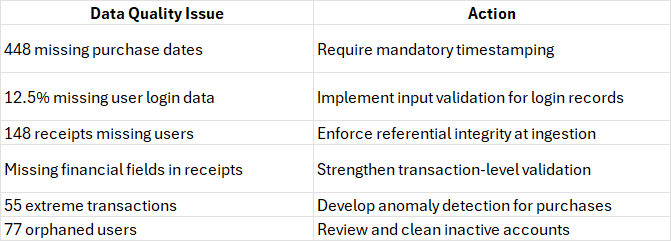





## 2. Data Loading & Cleaning for Analysis: Using Pandas to Read JSON

#### Objective:
1. Load JSON data efficiently from users.json, receipts.json, and brands.json.
2. Handle potential errors and convert the data into structured Pandas DataFrames.
3. Preview the dataset to understand its structure.

#### Implementation:

In [16]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


def load_json(file_path):
    #Loading a JSON file that may contain multiple objects per line NDJSON format
    try:
        with open(file_path, "r") as f:
            data = [json.loads(line) for line in f]
        return pd.json_normalize(data)
    except Exception as e:
        print(f"[ERROR] Failed to load {file_path}: {e}")
        return pd.DataFrame()

# Load datasets
users_df = load_json("users.json")
receipts_df = load_json("receipts.json")
brands_df = load_json("brands.json")

# Print initial column names
print("\n Columns in Each Dataset:")
print(f"[USERS_DF] Columns: {users_df.columns.tolist()}")
print(f"[RECEIPTS_DF] Columns: {receipts_df.columns.tolist()}")
print(f"[BRANDS_DF] Columns: {brands_df.columns.tolist()}")

# Display sample data
users_df.head()
receipts_df.head()
brands_df.head()




 Columns in Each Dataset:
[USERS_DF] Columns: ['active', 'role', 'signUpSource', 'state', '_id.$oid', 'createdDate.$date', 'lastLogin.$date']
[RECEIPTS_DF] Columns: ['bonusPointsEarned', 'bonusPointsEarnedReason', 'pointsEarned', 'purchasedItemCount', 'rewardsReceiptItemList', 'rewardsReceiptStatus', 'totalSpent', 'userId', '_id.$oid', 'createDate.$date', 'dateScanned.$date', 'finishedDate.$date', 'modifyDate.$date', 'pointsAwardedDate.$date', 'purchaseDate.$date']
[BRANDS_DF] Columns: ['barcode', 'category', 'categoryCode', 'name', 'topBrand', '_id.$oid', 'cpg.$id.$oid', 'cpg.$ref', 'brandCode']


,barcode,category,categoryCode,name,topBrand,_id.$oid,cpg.$id.$oid,cpg.$ref,brandCode
0,511111019862,Baking,BAKING,test brand @1612366101024,False,601ac115be37ce2ead437551,601ac114be37ce2ead437550,Cogs,NaN
1,511111519928,Beverages,BEVERAGES,Starbucks,False,601c5460be37ce2ead43755f,5332f5fbe4b03c9a25efd0ba,Cogs,STARBUCKS
2,511111819905,Baking,BAKING,test brand @1612366146176,False,601ac142be37ce2ead43755d,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146176
3,511111519874,Baking,BAKING,test brand @1612366146051,False,601ac142be37ce2ead43755a,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146051
4,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,601ac142be37ce2ead43755e,5332fa12e4b03c9a25efd1e7,Cogs,TEST BRANDCODE @1612366146827


#### Observations:
- Users Data: Contains user details (_id, state, createdDate, lastLogin), but timestamps may require transformation.
- Receipts Data: Includes transactions (totalSpent, purchaseDate, rewardsReceiptItemList), with potential missing or nested data.
- Brands Data: Stores brand details (barcode, category, brandCode), with possible duplicate or inconsistent entries.

### 2.1 Column Standardization

#### Objective:
1. Standardize column names across datasets for consistency.
2. Convert nested JSON keys into readable names.
3. Ensure unique naming conventions, especially for IDs in the brands dataset.

#### Implementation:

In [17]:
# Define column name mappings for consistency
column_mapping = {
    "_id.$oid": "_id",
    "createDate.$date": "createdDate",
    "dateScanned.$date": "dateScanned",
    "finishedDate.$date": "finishedDate",
    "modifyDate.$date": "modifyDate",
    "pointsAwardedDate.$date": "pointsAwardedDate",
    "purchaseDate.$date": "purchaseDate",
    "lastLogin.$date": "lastLogin",
    "topBrand": "top_brand",

    # Adjustments for Brands dataset
    "_id": "brand_id",
    "cpg.$id.$oid": "cpg_id",
    "cpg.$ref": "cpg_ref"
}

# Apply renaming dynamically
for df in [users_df, receipts_df, brands_df]:
    df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns}, inplace=True)

# Explicitly fix `_id` in Users and Brands datasets
if "_id" in users_df.columns:
    users_df.rename(columns={"_id": "user_id"}, inplace=True)

if "_id" in brands_df.columns:
    brands_df.rename(columns={"_id": "brand_id"}, inplace=True)

# Display updated column names
print("\nUpdated Column Names:")
print("Users:", users_df.columns.tolist())
print("Receipts:", receipts_df.columns.tolist())
print("Brands:", brands_df.columns.tolist())


Updated Column Names:
Users: ['active', 'role', 'signUpSource', 'state', 'user_id', 'createdDate.$date', 'lastLogin']
Receipts: ['bonusPointsEarned', 'bonusPointsEarnedReason', 'pointsEarned', 'purchasedItemCount', 'rewardsReceiptItemList', 'rewardsReceiptStatus', 'totalSpent', 'userId', '_id', 'createdDate', 'dateScanned', 'finishedDate', 'modifyDate', 'pointsAwardedDate', 'purchaseDate']
Brands: ['barcode', 'category', 'categoryCode', 'name', 'top_brand', 'brand_id', 'cpg_id', 'cpg_ref', 'brandCode']


#### Observations:
- Column names are now more readable and uniform across datasets.
- This simplifies future queries and ensures better data integrity.

### 2.2 Schema Validation

#### Objective:
1. Convert timestamp fields into readable datetime format.
2. Ensure numerical fields are correctly stored as numeric data types and validate transformed data to confirm accuracy.

#### Implementation:

In [19]:
# Column Name Standardization
column_mapping = {
    "_id.$oid": "_id",
    "createdDate.$date": "createdDate",
    "createDate.$date": "createdDate",
    "dateScanned.$date": "dateScanned",
    "finishedDate.$date": "finishedDate",
    "modifyDate.$date": "modifyDate",
    "pointsAwardedDate.$date": "pointsAwardedDate",
    "purchaseDate.$date": "purchaseDate",
    "lastLogin.$date": "lastLogin",
    "topBrand": "top_brand",
    "cpg.$id.$oid": "cpg_id",
    "cpg.$ref": "cpg_ref",
    "userId": "user_id"
}

# Applying renaming dynamically
for df_name, df in zip(["Users", "Receipts", "Brands"], [users_df, receipts_df, brands_df]):
    df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns}, inplace=True)



# Converting Date Fields

# Function to Convert Date Fields
def convert_datetime(df, columns):
    """Convert timestamp fields dynamically from seconds or milliseconds."""
    for col in columns:
        if col in df.columns and df[col].dtype in ["int64", "float64"]:
            max_value = df[col].max()
            unit = "s" if max_value < 1e10 else "ms"
            df[col] = pd.to_datetime(df[col], unit=unit, errors="coerce")

# Applying datetime conversion
convert_datetime(users_df, ["createdDate", "lastLogin"])
convert_datetime(receipts_df, ["createdDate", "purchaseDate", "dateScanned", "finishedDate", "modifyDate", "pointsAwardedDate"])



# Converting Data Types

# Converting Numeric Fields
numeric_fields = ["totalSpent", "pointsEarned", "bonusPointsEarned", "purchasedItemCount"]
for col in numeric_fields:
    if col in receipts_df.columns:
        receipts_df[col] = pd.to_numeric(receipts_df[col], errors="coerce")

# Converting Boolean Fields
if "top_brand" in brands_df.columns:
    brands_df["top_brand"] = brands_df["top_brand"].astype(bool)

# Converting Text Fields
text_columns_users = ["role", "signUpSource", "state"]
text_columns_receipts = ["bonusPointsEarnedReason", "rewardsReceiptStatus"]
text_columns_brands = ["category", "name", "cpg_id", "cpg_ref"]

for col in text_columns_users:
    if col in users_df.columns:
        users_df[col] = users_df[col].astype(str)

for col in text_columns_receipts:
    if col in receipts_df.columns:
        receipts_df[col] = receipts_df[col].astype(str)

for col in text_columns_brands:
    if col in brands_df.columns:
        brands_df[col] = brands_df[col].astype(str)

# Converting Identifier Fields
id_columns = ["user_id", "barcode", "categoryCode", "brandCode"]
for col in id_columns:
    for df in [users_df, receipts_df, brands_df]:
        if col in df.columns:
            df[col] = df[col].astype(str)



# Printing Final Column Data Types
print("\nColumn Data Types AFTER Transformation:")
for dataset_name, df in [("Users", users_df), ("Receipts", receipts_df), ("Brands", brands_df)]:
    print(f"\n{dataset_name} Column Data Types:\n{df.dtypes}")





Column Data Types AFTER Transformation:

Users Column Data Types:
active                    bool
role                    object
signUpSource            object
state                   object
user_id                 object
createdDate     datetime64[ns]
lastLogin       datetime64[ns]
dtype: object

Receipts Column Data Types:
bonusPointsEarned                 float64
bonusPointsEarnedReason            object
pointsEarned                      float64
purchasedItemCount                float64
rewardsReceiptItemList             object
rewardsReceiptStatus               object
totalSpent                        float64
user_id                            object
_id                                object
createdDate                datetime64[ns]
dateScanned                datetime64[ns]
finishedDate               datetime64[ns]
modifyDate                 datetime64[ns]
pointsAwardedDate          datetime64[ns]
purchaseDate               datetime64[ns]
dtype: object

Brands Column Data Types:
ba

#### Observations:
- Date Fields: Transformed successfully from milliseconds to datetime, enabling time-based analysis.
- Numerical Data: Now stored in the correct format, preventing calculation errors.
- Validation: Ensured the correctness of transformations by checking sample values.

### 2.3 Handling Missing Values

#### Objective:
1. Identify missing values across datasets.
2. Flag incomplete records for further analysis.

#### Implementation:

In [27]:
# Check for missing values in each dataset
print("Missing Values Count:")
print("Users Data:\n", users_df.isnull().sum())
print("Receipts Data:\n", receipts_df.isnull().sum())
print("Brands Data:\n", brands_df.isnull().sum())

# Flag incomplete records
incomplete_users = users_df[users_df.isnull().any(axis=1)]
incomplete_receipts = receipts_df[receipts_df.isnull().any(axis=1)]
print(f"\nIncomplete User Records: {len(incomplete_users)}")
print(f"Incomplete Receipt Records: {len(incomplete_receipts)}")


Missing Values Count:
Users Data:
 active           0
role             0
signUpSource     0
state            0
user_id          0
createdDate      0
lastLogin       62
dtype: int64
Receipts Data:
 bonusPointsEarned          575
bonusPointsEarnedReason      0
pointsEarned               510
purchasedItemCount         484
rewardsReceiptItemList       0
rewardsReceiptStatus         0
totalSpent                 435
user_id                      0
_id                          0
createdDate                  0
dateScanned                  0
finishedDate               551
modifyDate                   0
pointsAwardedDate          582
purchaseDate               448
totalSpent_log             435
dtype: int64
Brands Data:
 barcode         0
category        0
categoryCode    0
name            0
top_brand       0
brand_id        0
cpg_id          0
cpg_ref         0
brandCode       0
dtype: int64

Incomplete User Records: 62
Incomplete Receipt Records: 663


#### Observations:
- Users Dataset:
   The lastLogin field has 62 missing values, meaning these users have no recorded login activity.
Other critical fields such as active, role, signUpSource, and createdDate are fully populated, ensuring user records are mostly intact.

- Receipts Dataset:

  1. bonusPointsEarned (575 missing), pointsEarned (510 missing) –  Potential data entry gaps in reward point calculations.
  2. purchasedItemCount (484 missing) – This could impact item-level purchase analytics.
  3. totalSpent (435 missing) – Missing transaction values may skew financial insights.
  4. purchaseDate (448 missing) – Essential for time-based analysis; missing dates may render these records unusable.
  5. finishedDate (551 missing) & pointsAwardedDate (582 missing) – Indicates incomplete or unprocessed transactions.

- Brands Dataset:
  No missing values across all fields, indicating the brand data is well-structured and complete.

### 2.4 Duplicate Detetction

#### Objective:
1. Identify duplicate records across datasets.
2. Ensure primary key uniqueness (_id) to maintain data integrity.
3. Handle list-type columns properly before duplicate detection.

#### Implementation:

In [28]:
def check_duplicates(df, subset_key, dataset_name):
    #Checking for duplicate rows and primary key duplicates, handling list-type columns.

    # Converting any list-type columns to strings before checking for duplicates
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():  # Detect lists
            df[col] = df[col].astype(str)  # Convert lists to strings

    # Check full row duplicates
    full_duplicates = df.duplicated().sum()

    # Check for key-based duplicates if the key exists in the dataset
    key_duplicates = df.duplicated(subset=[subset_key]).sum() if subset_key in df.columns else "N/A"

    print(f"\n{dataset_name} Duplicate Records:")
    print(f"- Full duplicates: {full_duplicates}")

check_duplicates(users_df, "_id", "Users")
check_duplicates(receipts_df, "_id", "Receipts")
check_duplicates(brands_df, "_id", "Brands")


Users Duplicate Records:
- Full duplicates: 283

Receipts Duplicate Records:
- Full duplicates: 0

Brands Duplicate Records:
- Full duplicates: 0


#### Observations:
- Users Dataset: 283 full duplicates detected, indicating data redundancy.
- Receipts Dataset: No full duplicates found, suggesting a clean dataset.
- Brands Dataset: No full duplicates detected, ensuring data uniqueness.

## 3. Data Quality Checks

### 3.1 Referential Integrity Check

#### Objective:
1. Ensure data consistency between the receipts and users datasets.
2. Verify that all receipts have a corresponding user in the users dataset.
3. Detect orphaned transactions (i.e., receipts linked to missing or invalid user IDs).

#### Implementation:

In [29]:
# Referential Integrity Check: Identifying invalid receipts with non-existent user IDs
invalid_receipts = receipts_df[~receipts_df['user_id'].isin(users_df['user_id'])]

# Display the count of invalid receipts
print(f"\nInvalid Receipts (User ID Not Found): {len(invalid_receipts)}")



Invalid Receipts (User ID Not Found): 148


#### Observations:

- 148 receipts have userId values that do not exist in the Users dataset.
- These receipts are due to missing user records, data import errors, or deleted accounts.

### 3.2 Orphaned Data Detection

#### Objective:
1. Identify users who exist in the system but have never made a transaction.
2. Ensure that the Users dataset aligns with the Receipts dataset by checking for users who do not have any receipts.
3. Detect potential data quality issues, such as inactive or abandoned accounts.

#### Implementation:

In [30]:
# Orphaned Data Detection
orphaned_users = users_df[~users_df['user_id'].isin(receipts_df['user_id'])]
print(f"\nOrphaned User Records: {len(orphaned_users)}")



Orphaned User Records: 77


#### Observations:

- 77 orphaned users were detected, meaning 77 users exist in the database without any associated receipts.
- This could indicate inactive users, failed transactions, or onboarding drop-offs where users registered but never uploaded their receipts.

### 3.3 Stale User Detection

#### Objective:
1. Identify users who have not logged in for over six months based on the latest recorded login activity.
2. Ensure dynamic detection by computing inactivity relative to the most recent login timestamp in the dataset, rather than hardcoding a static date.
3. Assess potential user disengagement and detect accounts that may need re-engagement efforts.

#### Implementation:

In [31]:
# Stale Use Detection
max_last_login = users_df["lastLogin"].max()
inactive_threshold = max_last_login - pd.DateOffset(months=6)

stale_users_dynamic = users_df[users_df["lastLogin"] < inactive_threshold]
print(f"\nUsers who have not logged in for 6+ months: {stale_users_dynamic.shape[0]}")



Users who have not logged in for 6+ months: 1


#### Results & Observations

- 1 user have been inactive for over six months, indicating a potential drop-off in user engagement.
- This insight can be used for re-engagement strategies, such as personalized promotions, reminders, or targeted outreach to bring back any inactive users.

## 4. Outlier Analysis and Transformation

### 4.1 Outlier Detetction (IQR Method)

#### Objective:
1. Identify anomalous transactions by detecting extreme values in the totalSpent column.
2. Ensure robust statistical filtering by applying the Interquartile Range (IQR) method, which dynamically determines thresholds based on data distribution.
3. Improve data reliability by flagging and handling outliers that may indicate incorrect entries, fraud, or unusual spending behavior

#### Implementation:

In [32]:
# Outlier detection using Interquartile range (IQR)
def detect_outliers_iqr(df, column):

    if column in df.columns:
        df[column] = pd.to_numeric(df[column], errors="coerce")  # Ensure column is numeric
        df = df.dropna(subset=[column])  # Remove null values

        # IQR thresholds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifying outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        print(f"\nOutliers detected in {column}: {len(outliers)}")
        return outliers
    else:
        print(f"\nColumn '{column}' not found in dataset.")
        return pd.DataFrame()

# Outlier detection for totalSpent
outliers_total_spent = detect_outliers_iqr(receipts_df, "totalSpent")



Outliers detected in totalSpent: 55


#### Observations:
55 transactions were identified as outliers in totalSpent.
These extreme values may indicate fraudulent transactions, data entry errors, or high-value purchases.

### 4.2 Log Transformation & Data Distribution

#### Objective:
1. Detect outliers in totalSpent using boxplots and histograms.
2. Analyze the distribution of spending patterns.
3. Apply log transformation (log1p) to handle extreme skewness in the data.
4. Identify spending behavior trends to improve data-driven decision-making.

#### Implementation:



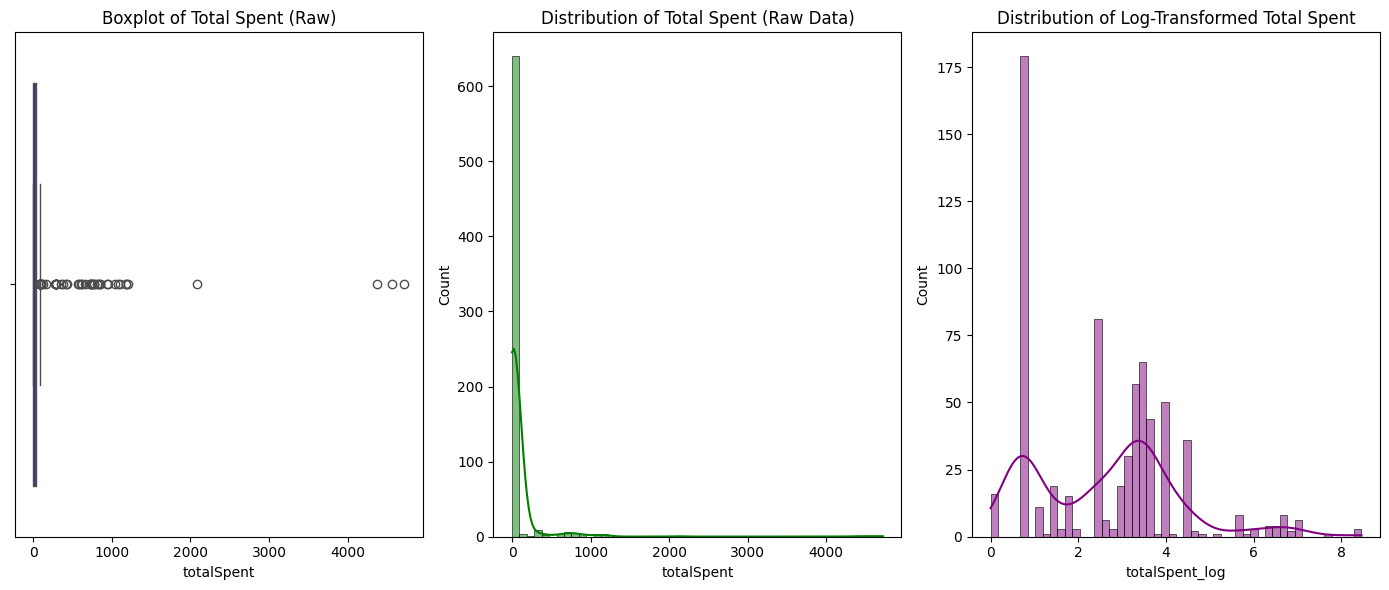

In [33]:
# Avoid log transformation on zero or negative values
receipts_df["totalSpent_log"] = np.log1p(receipts_df["totalSpent"])  # log(1+x) transformation to handle zero values

plt.figure(figsize=(14, 6))

# Boxplot (Raw Data)
plt.subplot(1, 3, 1)
sns.boxplot(x=receipts_df["totalSpent"], color="blue")
plt.title("Boxplot of Total Spent (Raw)")

# Histogram & KDE Plot (Raw Data)
plt.subplot(1, 3, 2)
sns.histplot(receipts_df["totalSpent"], bins=50, kde=True, color="green")
plt.title("Distribution of Total Spent (Raw Data)")

# Histogram & KDE Plot (Log-Transformed)
plt.subplot(1, 3, 3)
sns.histplot(receipts_df["totalSpent_log"], bins=50, kde=True, color="purple")
plt.title("Distribution of Log-Transformed Total Spent")

plt.tight_layout()
plt.show()


#### Observations:

- Boxplot of Total Spent (Raw Data) :
  Several high-value transactions (outliers) are visible.
Most purchases are clustered at low spending values, with extreme cases reaching thousands of dollars.

- Distribution of Total Spent (Raw Data):
  The histogram is highly right-skewed, indicating a few very high-spending receipts.
The majority of transactions are low-value, confirming an uneven distribution.

- Distribution of Log-Transformed Total Spent: The log transformation smooths the distribution, making spending patterns easier to interpret.
Bimodal peaks suggest two groups of spenders:
    1. Low spenders (~$1 to ~$10) dollars,
    2. Higher spenders (~$20+), potentially repeat customers or bulk buyers.

  The KDE (Kernel Density Estimate) shows a less skewed, more normal-like distribution.

## 5. Data Quality Action Plan

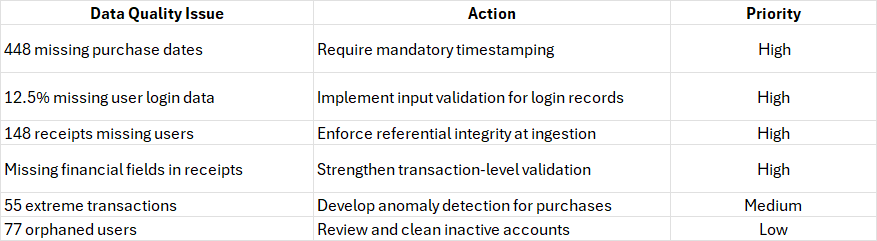

#### Short-Term Fixes
1. Validate user logins at input to prevent missing records.
2. Enforce referential integrity for receipts to ensure valid user references.
3. Apply imputation for missing reward-related fields (e.g., set bonusPointsEarned = 0)

#### Long-term Enhancements
1. Automate anomaly detection using Snowflake ML to flag extreme transactions dynamically.
2. Deploy Snowflake Data Pipelines for real-time data validation and cleansing.
3. Integrate Snowflake with cloud-based ETL tools (AWS Glue, DBT, or Airflow) to enforce quality checks at ingestion.
4. Leverage Snowflake's Snowpipe for Streaming Data to ensure real-time ingestion and validation.
5. Set up Snowflake Alerts and Notifications for missing timestamps and referential integrity issues.
6. Store transactional logs in cloud-based storage (AWS S3, Azure Blob) for long-term auditing and compliance.

Implementing these enhancements will streamline data ingestion, improve validation accuracy, and ensure robust data quality. These improvements will also facilitate more reliable analysis, enabling data-driven decision-making for business insights.

## 6. Key Findings & Next Steps

- Address Data Gaps: Investigate missing receipts and user references to mitigate data loss risks.
- Improve Data Consistency: Implement validation rules to enforce financial completeness and ensure transaction integrity.
- Enhance Outlier Handling: Integrate anomaly detection for extreme financial transactions (e.g., similar to UserFlagged in the Receipts table).
- Automate Data Quality Processes: Deploy Snowflake data quality pipelines with integrity constraints and automated alerts for inconsistencies.

Note: The Data Quality Analysis presented in this report is based on the information provided in the sample data files. Certain assumptions were made based on contextual insights and an understanding of Fetch’s operations to enhance the evaluation.







